## Access Mooring Satellite Altimetry Calibration Validation (Parquet)

This Jupyter notebook demonstrates how to access and plot mooring satellite altimetry calibration validation data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/78d588ed-79dd-47e2-b806-d39025194e7e).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/mooring_satellite_altimetry_calibration_validation.ipynb).


In [1]:
dataset_name = "mooring_satellite_altimetry_calibration_validation"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 53ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 53 ms, sys: 13.3 ms, total: 66.3 ms
Wall time: 6.47 s


In [5]:
aodn_dataset.dataset.partitioning.schema

site_code: string
instrument: string
timestamp: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('site_code')
print(list(unique_partition_value))  # showing a subset only

unique_partition_value = aodn_dataset.get_unique_partition_values('instrument')
print(list(unique_partition_value))  # showing a subset only

['SRSBASSWS', 'SRSBASS3A', 'SRSSTOJAS', 'SRSBASS3B', 'SRSBASSWN', 'SRSBASJAS']
['SBE26', 'Aquad', 'SBE37', 'ST_CM']
CPU times: user 4.06 ms, sys: 2.02 ms, total: 6.08 ms
Wall time: 4.08 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


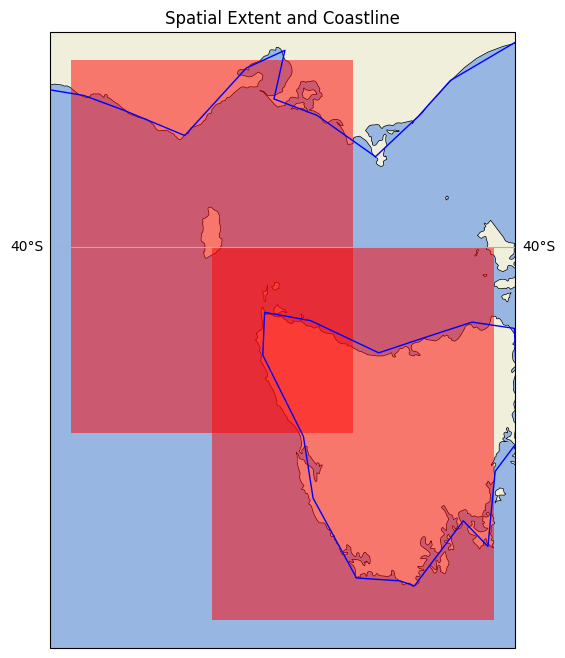

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2001-12-17 01:43:06.999995904'),
 Timestamp('2021-03-06 03:22:00.000001792'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:11:37,636 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/mooring_satellite_altimetry_calibration_validation.parquet
2025-06-05 13:11:37,750 - aodn.GetAodn - WARNING - Old 'dataset_medata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'timestamp': {'type': 'int64'},
 'polygon': {'type': 'string'},
 'filename': {'type': 'string'},
 'site_code': {'type': 'string'},
 'site': {'type': 'string'},
 'instrument': {'type': 'string'},
 'instrument_serial_number': {'type': 'string'},
 'TIME': {'type': 'timestamp[ns]',
  'long_name': 'time',
  'standard_name': 'time',
  'axis': 'T',
  'valid_min': 0.0,
  'valid_max': 90000.0,
  'uncertainty': 1.1574074074074073e-05,
  'local_time_zone': '+10'},
 'LONGITUDE': {'type': 'float',
  'long_name': 'longitude',
  'standard_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180.0,
  'valid_max': 180.0,
  'uncertainty': 0.0010000000474974513,
  'reference_datum': 'geographical coordinates, WGS84 projection'},
 'LATITUDE': {'type': 'float',
  'long_name': 'latitude',
  'standard_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90.0,
  'valid_max': 90.0,
  'uncertainty': 0.0010000000474974513,
  'reference_datum': 'geographical coor

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2017-08-01', 
                           date_end='2018-06-01', 
                           lat_min=-45, 
                           lat_max=-28, 
                           lon_min=140, 
                           lon_max=160)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493275 entries, 0 to 493274
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   filename                  493275 non-null  object        
 1   site                      493275 non-null  object        
 2   instrument_serial_number  493275 non-null  object        
 3   TIME                      493275 non-null  datetime64[ns]
 4   LONGITUDE                 493275 non-null  float32       
 5   LATITUDE                  493275 non-null  float32       
 6   NOMINAL_DEPTH             493275 non-null  float32       
 7   TEMP                      493275 non-null  float32       
 8   TEMP_quality_control      493275 non-null  int32         
 9   UCUR                      4039 non-null    float32       
 10  UCUR_quality_control      4039 non-null    float32       
 11  VCUR                      4039 non-null    float32       
 12  VC

In [ ]:
# Download subsetted data as CSV
df.aodn.download_as_csv()

In [11]:
df['NOMINAL_DEPTH'].unique()

array([27.5, 49. , 50. , 17.5, 30. , 41.5, 28. ], dtype=float32)

/tmp/ipykernel_671045/707641046.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis_r', len(unique_depths))  # Use the reversed colormap


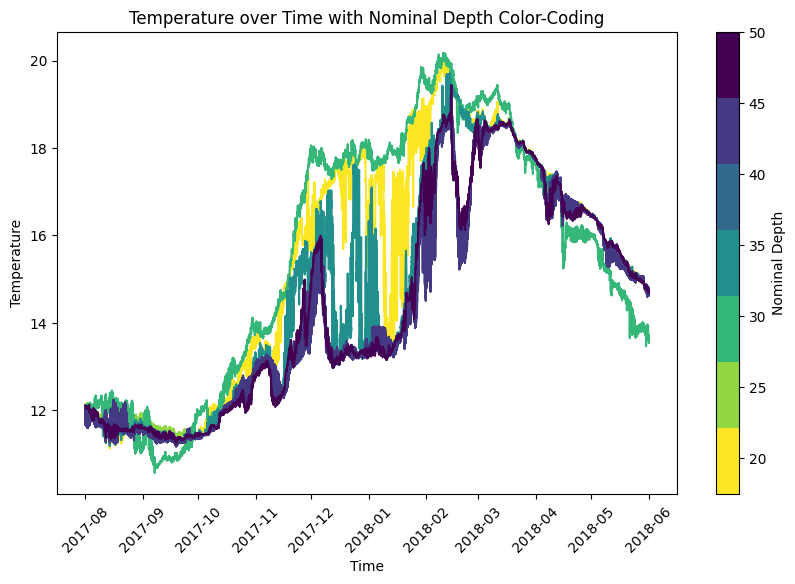

In [12]:
# Create a colormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt

unique_depths = sorted(df['NOMINAL_DEPTH'].unique())
cmap = cm.get_cmap('viridis_r', len(unique_depths))  # Use the reversed colormap

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data with color coding
for i, depth in enumerate(unique_depths):
    subset = df[df['NOMINAL_DEPTH'] == depth].sort_values('TIME')  # Sort by TIME
    ax.plot(subset['TIME'], subset['TEMP'], label=f'Depth {depth}', color=cmap(i / len(unique_depths)))

# Create a colorbar
norm = plt.Normalize(vmin=min(unique_depths), vmax=max(unique_depths))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Nominal Depth', orientation='vertical')

ax.set_xlabel('Time')
ax.set_ylabel('Temperature')
ax.set_title('Temperature over Time with Nominal Depth Color-Coding')
# Rotate the x-axis time labels to 45 degrees
plt.xticks(rotation=45)

plt.show()


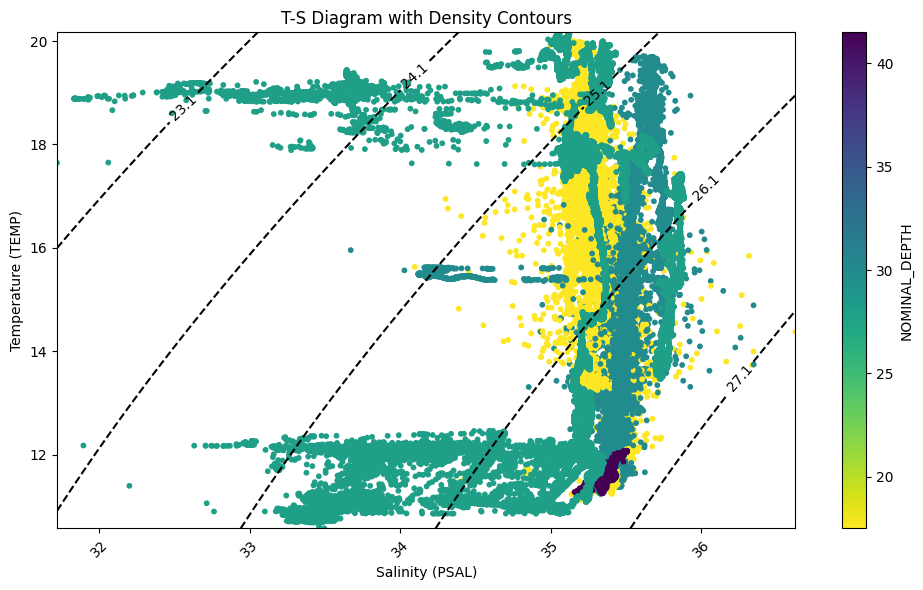

In [13]:
# Filter data where PSAL_quality_control == 1 and PSAL >= 25 (some weird values of 16. to check)
from DataQuery import plot_ts_diagram
filtered_df = df[(df['PSAL_quality_control'] == 1) & (df['PSAL'] >= 25)]

plot_ts_diagram(filtered_df, temp_col='TEMP', psal_col='PSAL', z_col='NOMINAL_DEPTH')

## Create a TIME and scalar/number filter

In [14]:
%%time
df = aodn_dataset.get_data(date_start='2010-07-12', date_end='2012-02-05', scalar_filter={'site_code': "SRSBASJAS"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452574 entries, 0 to 452573
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   filename                  452574 non-null  object        
 1   site                      452574 non-null  object        
 2   instrument_serial_number  452574 non-null  object        
 3   TIME                      452574 non-null  datetime64[ns]
 4   LONGITUDE                 452574 non-null  float32       
 5   LATITUDE                  452574 non-null  float32       
 6   NOMINAL_DEPTH             452574 non-null  float32       
 7   TEMP                      452574 non-null  float32       
 8   TEMP_quality_control      452574 non-null  int32         
 9   UCUR                      0 non-null       float32       
 10  UCUR_quality_control      0 non-null       float32       
 11  VCUR                      0 non-null       float32       
 12  VC

In [15]:
df

,filename,site,instrument_serial_number,TIME,LONGITUDE,LATITUDE,NOMINAL_DEPTH,TEMP,TEMP_quality_control,UCUR,...,CNDC,CNDC_quality_control,PRES,PRES_quality_control,PSAL,PSAL_quality_control,site_code,instrument,timestamp,polygon
0,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 00:42:00.000000768,145.593002,-40.650002,52.0,17.007999,1,NaN,...,NaN,NaN,62.808132,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
1,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 00:47:00.000002816,145.593002,-40.650002,52.0,17.007999,1,NaN,...,NaN,NaN,62.838955,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
2,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 00:52:00.000005120,145.593002,-40.650002,52.0,17.009001,1,NaN,...,NaN,NaN,62.856396,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
3,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 00:57:00.000007424,145.593002,-40.650002,52.0,17.009001,1,NaN,...,NaN,NaN,62.883217,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
4,IMOS_SRSALT_PT_20110404T003800Z_BASJAS_FV01_SB...,"Bass Strait, TAS",1146,2011-04-04 01:01:59.999999488,145.593002,-40.650002,52.0,17.010000,1,NaN,...,NaN,NaN,62.913002,1,NaN,NaN,SRSBASJAS,SBE26,1293840000,010300000001000000050000000000000000C061400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452569,IMOS_SRSALT_TCPS_20110826T022500Z_BASJAS_FV01_...,"Bass Strait, TAS",3365,2012-02-04 23:20:00.000002304,145.591995,-40.641998,48.0,20.295099,1,NaN,...,4.88306,1.0,45.088001,1,35.483311,1.0,SRSBASJAS,SBE37,1325376000,010300000001000000050000000000000000C061400000...
452570,IMOS_SRSALT_TCPS_20110826T022500Z_BASJAS_FV01_...,"Bass Strait, TAS",3365,2012-02-04 23:29:59.999996672,145.591995,-40.641998,48.0,20.295200,1,NaN,...,4.88315,1.0,45.106998,1,35.483955,1.0,SRSBASJAS,SBE37,1325376000,010300000001000000050000000000000000C061400000...
452571,IMOS_SRSALT_TCPS_20110826T022500Z_BASJAS_FV01_...,"Bass Strait, TAS",3365,2012-02-04 23:40:00.000001024,145.591995,-40.641998,48.0,20.294001,1,NaN,...,4.88257,1.0,45.040001,1,35.480251,1.0,SRSBASJAS,SBE37,1325376000,010300000001000000050000000000000000C061400000...
452572,IMOS_SRSALT_TCPS_20110826T022500Z_BASJAS_FV01_...,"Bass Strait, TAS",3365,2012-02-04 23:49:59.999995648,145.591995,-40.641998,48.0,20.294901,1,NaN,...,4.88286,1.0,44.985001,1,35.481884,1.0,SRSBASJAS,SBE37,1325376000,010300000001000000050000000000000000C061400000...
